In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("data/service-requests-received-by-public-works.csv")
df.head()

,REQUESTID,DATETIMEINIT,DESCRIPTION,REQCATEGORY,STATUS,DATETIMECLOSED,SRX,SRY,REFERREDTO,Location 1,Zip Codes
0,21135.0,7/13/2009 1:52:45PM,Residential Recycling Service Issues,RECYCLING,CLOSED,7/13/2009 1:52:47PM,0.0,0.0,NaN,"{'latitude': '37.80505999961946', 'longitude':...",1489.0
1,21324.0,8/11/2009 1:58:50PM,Residential Recycling Service Issues,RECYCLING,CLOSED,8/11/2009 1:58:55PM,0.0,0.0,NaN,"{'latitude': '37.80505999961946', 'longitude':...",1489.0
2,21548.0,10/5/2009 3:31:18PM,Residential Recycling Service Issues,RECYCLING,CLOSED,10/5/2009 3:31:23PM,0.0,0.0,NaN,"{'latitude': '37.80505999961946', 'longitude':...",1489.0
3,21950.0,3/24/2010 4:40:09PM,Residential Recycling Service Issues,RECYCLING,CLOSED,3/24/2010 4:40:28PM,0.0,0.0,NaN,"{'latitude': '37.80505999961946', 'longitude':...",1489.0
4,23206.0,8/25/2010 8:42:16AM,Business,RECYCLING,CLOSED,8/25/2010 8:42:19AM,0.0,0.0,NaN,"{'latitude': '37.80505999961946', 'longitude':...",1489.0


In [2]:
df = df[['DATETIMEINIT','DATETIMECLOSED','REQCATEGORY']]

df['DATETIMECLOSED'] = pd.to_datetime(df['DATETIMECLOSED'])
df['DATETIMEINIT'] = pd.to_datetime(df['DATETIMEINIT'])


In [3]:
df["HT"] = (df['DATETIMECLOSED'] - df['DATETIMEINIT']).dt.total_seconds()
df["BIN"] = df['DATETIMEINIT'].dt.round('15min') 


In [4]:
aht = df.groupby(["BIN",'REQCATEGORY'])['HT'].mean().reset_index()
volume = df.groupby(["BIN",'REQCATEGORY'])['HT'].count().reset_index()

In [5]:
full_time_range = pd.date_range(start=aht["BIN"].min(),end=aht["BIN"].max(),freq="15min")

In [6]:
volume = volume.pivot_table(index="BIN",columns="REQCATEGORY").reindex(full_time_range,fill_value=np.nan)
aht = aht.pivot_table(index="BIN",columns="REQCATEGORY").reindex(full_time_range,fill_value=np.nan)

In [7]:
aht.columns = aht.columns.droplevel(level=0)
volume.columns = volume.columns.droplevel(level=0)

BLDGMAINT
CUT_CLEAN
DRAINAGE
ELECTRICAL
FACILITIES
FIRE
GIS
GRAFFITI
ILLDUMP
KOCB
METER_REPAIR
OTHER
PARKS
RECYCLING
ROW
SEWERS
STREETSW
SURVEY
TRAFFIC
TRAFFIC_ENGIN
TREES
VEGCONTR
WATERSHED


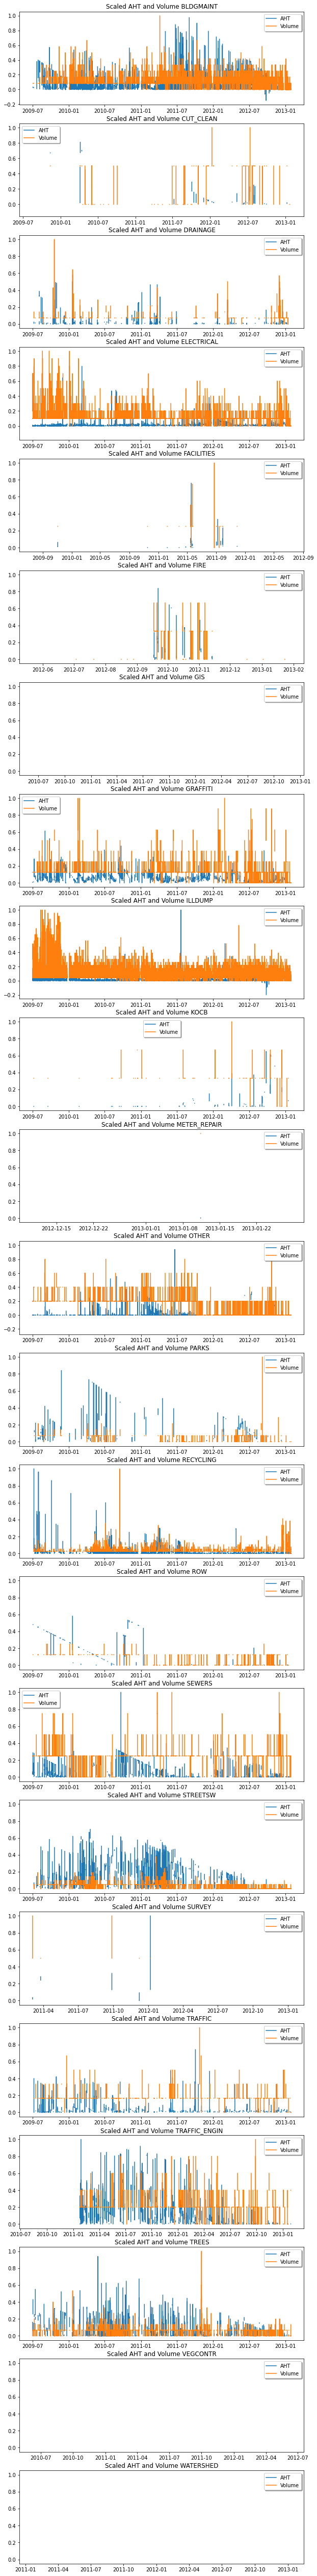

In [8]:
import matplotlib.pyplot as plt

num_of_slices = len(aht.columns)
fig, axs = plt.subplots(num_of_slices,figsize=(10,4*num_of_slices))

for index,col in enumerate(aht.columns):
    print(col)
    axs[index].plot(aht[col]/aht[col].max(),label="AHT")
    axs[index].plot(volume[col]/volume[col].max(),label="Volume")
    axs[index].title.set_text(f"Scaled AHT and Volume {col}")
    axs[index].legend(shadow=True, fancybox=True)


In [10]:
seleceted = ["TREES",'STREETSW','SEWERS','ILLDUMP']
aht = aht[seleceted].fillna(-2)
volume = volume[seleceted].fillna(-2)

In [12]:
volume

REQCATEGORY,TREES,STREETSW,SEWERS,ILLDUMP
2009-07-01 08:00:00,-2.0,-2.0,-2.0,1.0
2009-07-01 08:15:00,0.0,1.0,-2.0,1.0
2009-07-01 08:30:00,-2.0,-2.0,-2.0,1.0
2009-07-01 08:45:00,-2.0,-2.0,-2.0,-2.0
2009-07-01 09:00:00,-2.0,-2.0,1.0,1.0
...,...,...,...,...
2013-01-29 21:15:00,-2.0,-2.0,-2.0,-2.0
2013-01-29 21:30:00,-2.0,-2.0,-2.0,-2.0
2013-01-29 21:45:00,-2.0,-2.0,-2.0,-2.0
2013-01-29 22:00:00,-2.0,-2.0,-2.0,-2.0


In [40]:
requested_data_length = 4*14*(14+1)
number_of_values_in_window = (~volume.isna()).rolling(window=requested_data_length).count() 
number_of_values_in_window == requested_data_length

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/window/rolling.py:2010: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  warnings.warn(


REQCATEGORY,TREES,STREETSW,SEWERS,ILLDUMP
2009-07-01 08:00:00,False,False,False,False
2009-07-01 08:15:00,False,False,False,False
2009-07-01 08:30:00,False,False,False,False
2009-07-01 08:45:00,False,False,False,False
2009-07-01 09:00:00,False,False,False,False
...,...,...,...,...
2013-01-29 21:15:00,True,True,True,True
2013-01-29 21:30:00,True,True,True,True
2013-01-29 21:45:00,True,True,True,True
2013-01-29 22:00:00,True,True,True,True


In [1]:
aht[seleceted].tail(10)

NameError: name 'aht' is not defined